# Transition Path

In this notebook, I solve and simulate the housing model along a **transition path** stemming from an interest rate shock

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

# Set the number of threads in numba
nb.set_num_threads(4)

## Test how PE path looks

Solve the Initial Steady State

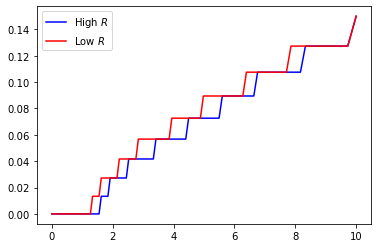

In [448]:
plt.plot(model.par.grid_m, model.sol_path.d_adj[199,0,1,:], color = 'blue', linewidth = '1.5', label = r'High $R$')
plt.plot(model.par.grid_m, model.sol_path.d_adj[200,0,1,:], color = 'red', linewidth = '1.5', label = r'Low $R$')
plt.legend()

In [481]:
model = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model.precompile_numba()
model.solve()

Solve and Simulate Along a Transition Path

In [484]:
# model.par.path_ph[199] = model.par.ph
model.par.path_ph[200] =  7.0

In [485]:
model.solve_path()
model.simulate_path()

Plot the results

In [489]:
h_path[201]

0.055696669950235984

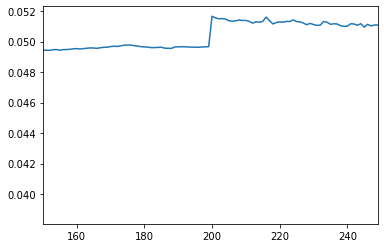

In [563]:
# define
h_path = np.mean(model.sim_path.d, axis=1)

# plot
plt.plot(range(len(h_path)),h_path)
plt.xlim(150,249)
# plt.ylim(0.045,0.065)
plt.show()

## Test Relaxation Algorithm

Supply function

In [490]:
# Write test function
def Hs_prime(x):
    
    # Parameters
    a = 9000
    b = 6.4593010477953685 - a*0.05
    
    # Set negatives to zero
    y = a*x + b
    
    return max(y,0)

Setup

In [491]:
# a. allocate
path_ph_ = np.zeros(50)
path_ph = np.zeros(50)

# b. setting
nu = 0.999 # relaxation parameter
max_iter = 500 # maximum number of iterations

# Set path of prices
path_ph[:] = model.par.ph
model.par.path_ph[model.par.sim_T:model.par.sim_T+50] = path_ph

Solve and simulate along path - **start here again**

In [556]:
model.solve_path()
model.simulate_path()

Find implied house price

In [557]:
for t in range(50):
    path_ph_[t] = Hs_prime(np.mean(model.sim_path.d, axis=1)[model.par.sim_T+t])

Compute difference between implied and actual prices

In [558]:
max_abs_diff = np.max(np.abs(path_ph-path_ph_))
print(max_abs_diff)

14.862353835967182


Check

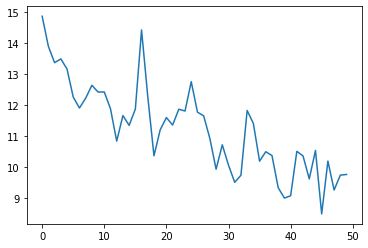

In [559]:
y = path_ph_ - path_ph
plt.plot(y)

Update price sequence

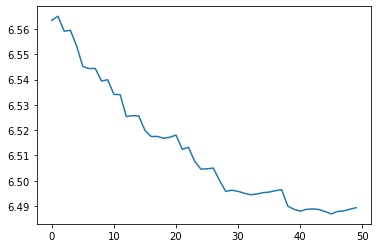

In [560]:
path_ph = nu*path_ph + (1-nu)*path_ph_
plt.plot(path_ph)

Run again with updated price sequence

In [561]:
model.par.path_ph[model.par.sim_T:model.par.sim_T+50] = path_ph

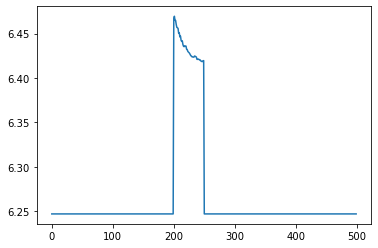

In [527]:
plt.plot(model.par.path_ph)

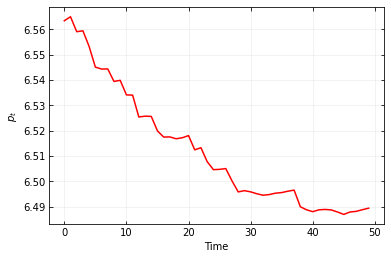

In [566]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(0,50),path_ph, color = 'red', label = 'Demand',zorder=2)

# ax.set_xlim(0.0,0.14)
# ax.set_ylim(2.5,9.4)
ax.set_xlabel('Time')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_ph.pdf')

## Find Equilibrium Along a Transition Path

In [2]:
# Write test function
def Hs_prime(x):
    
    # Parameters
    a = 9000
    b = 6.4593010477953685 - a*0.05
    
    # Set negatives to zero
    y = a*x + b
    
    return max(y,0)

## Apply relaxation algorithm 

In [3]:
# Initialize model and solve initial steady state
model_path = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model_path.precompile_numba()
model_path.solve()

In [5]:
# a. allocate
path_ph_ = np.zeros(50)
path_ph = np.zeros(50)

# b. setting
nu = 0.999 # relaxation parameter
max_iter = 500 # maximum number of iterations

# c. Set path of prices
path_ph[:] = model_path.par.ph
model_path.par.path_ph[model_path.par.sim_T:model_path.par.sim_T+50] = path_ph

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model_path.solve_path()
    model_path.simulate_path()

    # iii. implied housing price
    for t in range(50):
        path_ph_[t] = Hs_prime(np.mean(model_path.sim_path.d, axis=1)[model_path.par.sim_T+t])

    # iv. difference
    max_abs_diff = np.max(np.abs(path_ph-path_ph_))
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 5.0: break # test different values of this threshold

    # v. update
    path_ph = nu*path_ph + (1-nu)*path_ph_
    model_path.par.path_ph[model_path.par.sim_T:model_path.par.sim_T+50] = path_ph    
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))

1th iteration: dif = 60.57326282119359
2th iteration: dif = 64.85530906626866
3th iteration: dif = 42.48419865794614
4th iteration: dif = 35.21787992173073
5th iteration: dif = 30.539942531814447
6th iteration: dif = 25.907749154670253
7th iteration: dif = 22.31804933364343
8th iteration: dif = 19.23460920159094
9th iteration: dif = 15.790051997980637
10th iteration: dif = 13.67665753293667
11th iteration: dif = 12.033837673401148
12th iteration: dif = 10.489682112289824
13th iteration: dif = 8.321633116076391
14th iteration: dif = 7.579360493339318
15th iteration: dif = 6.361831724271177
16th iteration: dif = 6.114672839163849
17th iteration: dif = 5.353585054175081


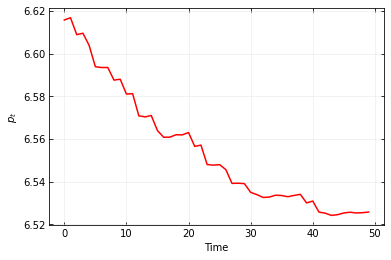

In [9]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(0,50),path_ph, color = 'red', label = 'Demand',zorder=2)

# ax.set_xlim(0.0,0.14)
# ax.set_ylim(2.5,9.4)
ax.set_xlabel('Time')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_ph.pdf')

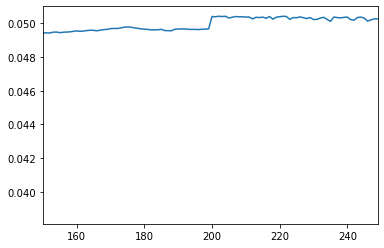

In [8]:
# define
h_path = np.mean(model_path.sim_path.d, axis=1)

# plot
plt.plot(range(len(h_path)),h_path)
plt.xlim(150,249)
# plt.ylim(0.045,0.065)
plt.show()